<a href="https://colab.research.google.com/github/doomchitdoomchit/mini-project/blob/main/gray2color/gray2color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# gray2color
: 흑백 스케일을 컬러 스케일로

관련 논문 : https://arxiv.org/pdf/1603.08511.pdf

엄청난 도움되는 영상과 블로그 
- https://www.youtube.com/watch?v=8XFFJlA_Vig
- https://blog.naver.com/dnjswns2280/221890535107

## 들어가기 앞서.
: 본 py는 unet을 이용하여, 흑백 스케일을 컬러 스케일로 변환하는 py이다.

unet의 특징 : 단순히 이미지 분류를 하는 것에서 벗어나, 이미지의 특정 물체(영역)에 레이블을 달아 표현하는 image segmentation에 중점을 둔 모델이다.

기존의 모델과 다른점은
  1. 속도가 빠르다.   
    sliding window[$^{inform}$](https://ramees.tistory.com/52)보다 빠르게 patch 방식을 채택하여, 이미지를 전부 조금씩 잘라서 훑어보는것이 아니라, 이미지 전체를 격자 모양으로 잘라서 한번에 인식한다. 
    
  2. Patch의 사이즈에 따른 trade off에 빠지지 않는다.
    기존의 방식은 한번에 넓은 구역을 보면, 전체적인 그림의 인식 확률은 좋아지지만 Localization(어떤 구역이 어떤 레이블인지)이 부족해지고, 반대로 좁은 구역을 보면 더 세분화된 localization 이 가능하지만 인식률이 떨어지는 단점이 있었다.


In [ ]:
from keras import layers, models, optimizers
from keras import datasets
from keras import backend
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [ ]:
class UNET(models.Model):
  def __init__(self, org_shape, n_ch):
    channel_index = 3 if backend.image_data_format() == 'channels_last' else 1

    def conv(x, n_f, mp_flag = True):
      x = layers.MaxPool2D((2, 2), padding = "same")(x) if mp_flag else x
      x = layers.Conv2D(n_f, (3, 3), padding = 'same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('tanh')(x)
      x = layers.Conv2D(n_f, (3, 3), padding = 'same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('tanh')(x)
      return x

    def deconv_unet(x, e, n_f):
      x = layers.UpSampling2D((2, 2))(x)
      x = layers.Concatenate(axis = channel_index)([x, e])
      x = layers.Conv2D(n_f, (3, 3), padding = 'same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('tanh')(x)
      x = layers.Conv2D(n_f, (3, 3), padding = 'same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('tanh')(x)
      return x

    original = layers.Input(shape = org_shape)

    c1 = conv(original, 16, False)
    c2 = conv(c1, 32)
    encoded = conv(c2, 64)

    x = deconv_unet(encoded, c2, 32)
    x = deconv_unet(x, c1, 16)
    decoded = layers.Conv2D(n_ch, (3, 3), activation = 'sigmoid', padding = 'same')(x)

    super().__init__(original, decoded)
    self.compile(optimizer = 'adadelta', loss = 'mse')

In [ ]:
class DATA():
  def __init__(self): 
    (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
    
    if backend.image_data_format() == 'channels_first':
      n_ch, img_rows, img_cols = x_train.shape[1:]
      input_shape = (1, img_rows, img_cols)
    else:
      img_rows, img_cols, n_ch = x_train.shape[1:]
      input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    def RGB2Gray(img, fmt):
      if fmt == 'channels_first':
        R = img[:, 0:1]
        G = img[:, 1:2]
        B = img[:, 2:3]
      else:
        R = img[..., 0:1]
        G = img[..., 1:2]
        B = img[..., 2:3]
      return 0.299 * R + 0.587 * G + 0.114 * B
    
    x_train_in = RGB2Gray(x_train, backend.image_data_format())
    x_test_in = RGB2Gray(x_test, backend.image_data_format())
    
    self.input_shape = input_shape
    self.x_train_in, self.x_train_out = x_train_in, x_train
    self.x_test_in, self.x_test_out = x_test_in, x_test
    self.n_ch = n_ch

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)
 
def plot_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

In [ ]:
data = DATA()
unet = UNET(data.input_shape, data.n_ch)
unet.summary()

170500096/170498071 [==============================] - 4s 0us/step
Model: "unet_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________

In [ ]:
def show_images(in_imgs, out_imgs, unet, sample_size=10):
  x_test_in = in_imgs[:sample_size]
  x_test_out = out_imgs[:sample_size]
  decoded_imgs = unet.predict(x_test_in, batch_size=sample_size)
  
  print("Before")
  print("x_test_in:", x_test_in.shape)
  print("decoded_imgs:", decoded_imgs.shape)
  print("x_test_out:", x_test_out.shape)
  
  if backend.image_data_format() == 'channels_first':
    x_test_out = x_test_out.swapaxes(1, 3).swapaxes(1, 2)
    decoded_imgs = decoded_imgs.swapaxes(1, 3).swapaxes(1, 2)
    
    x_test_in = x_test_in[:, 0, ...]
  else:
    x_test_in = x_test_in[..., 0]
  
  print("After")
  print("x_test_in:", x_test_in.shape)
  print("decoded_imgs:", decoded_imgs.shape)
  print("x_test_out:", x_test_out.shape)
    
  plt.figure(figsize=(20, 6))
  for i in range(sample_size):
    ax = plt.subplot(3, sample_size, i + 1)
    plt.imshow(x_test_in[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, sample_size, i + 1 + sample_size)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, sample_size, i + 1 + sample_size * 2)
    plt.imshow(x_test_out[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
  plt.show()

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 38s - loss: 0.0129 - val_loss: 0.0214
Epoch 2/10
 - 29s - loss: 0.0089 - val_loss: 0.0165
Epoch 3/10
 - 29s - loss: 0.0079 - val_loss: 0.0092
Epoch 4/10
 - 29s - loss: 0.0075 - val_loss: 0.0161
Epoch 5/10
 - 29s - loss: 0.0072 - val_loss: 0.0144
Epoch 6/10
 - 29s - loss: 0.0069 - val_loss: 0.0150
Epoch 7/10
 - 29s - loss: 0.0068 - val_loss: 0.0077
Epoch 8/10
 - 29s - loss: 0.0067 - val_loss: 0.0072
Epoch 9/10
 - 29s - loss: 0.0066 - val_loss: 0.0071
Epoch 10/10
 - 29s - loss: 0.0065 - val_loss: 0.0090
Before
x_test_in: (10, 32, 32, 1)
decoded_imgs: (10, 32, 32, 3)
x_test_out: (10, 32, 32, 3)
After
x_test_in: (10, 32, 32)
decoded_imgs: (10, 32, 32, 3)
x_test_out: (10, 32, 32, 3)


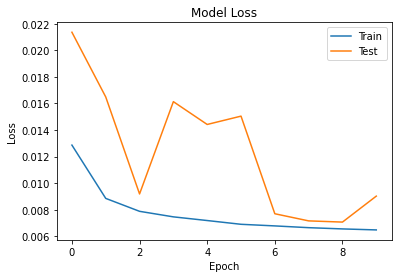

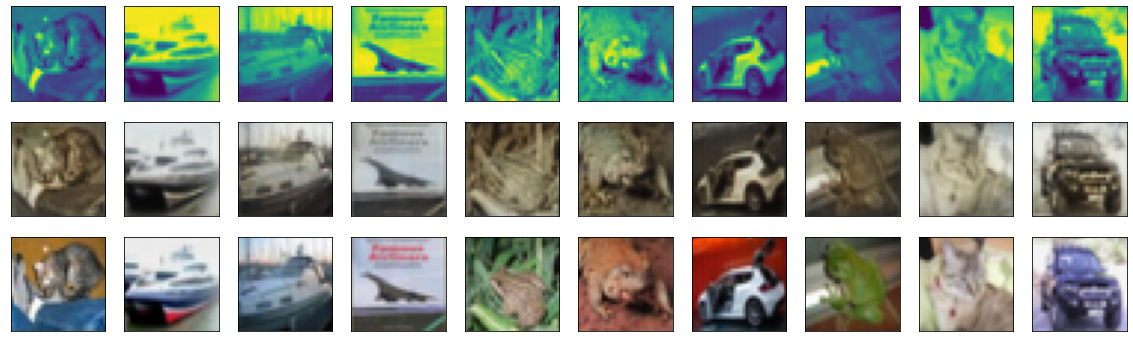

In [ ]:
def main(epochs=10, batch_size=128):
  data = DATA()
  unet = UNET(data.input_shape, data.n_ch)
  
  history = unet.fit(data.x_train_in, data.x_train_out,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=2)
  
  plot_loss(history)
  show_images(data.x_test_in, data.x_test_out, unet)
  
if __name__ == '__main__':
  main()